<a href="https://colab.research.google.com/github/junho328/Deep_learning_with_Pytorch/blob/main/Pytorch_CH9_Performance_Improvement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regularization
- Train Deep-learning model with preventing the Overfitting

###Data augmentation

In [ ]:
import torchvision.transforms as tr
import PIL

transf = tr.Compose([tr.ToPILImage(),tr.RandomCrop(60),
                     tr.ColorJitter(brightness = 0.1, contrast= 0.1, saturation = 0.1,hue = 0.1),
                     tr.RandomHorizontalFlip(),tr.ToTensor()])

###Early stopping
- 손실 함수값이 작다고 반드시 정확도가 높은 것은 아니다.
- 직접적으로 시험 데이터를 사용하기 보다는 검증 데이터를 사용한다. 시험 데이터는 오직 평가에만 사용한다.

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [ ]:
#학습,검증,시험 데이터
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
dataset = torchvision.datasets.CIFAR10(root='./data',train=True,
                                       download=True,transform=transform)
trainset,valset = torch.utils.data.random_split(dataset, [30000,20000])
trainloader= torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available.')

cuda:0 is available.


In [ ]:
#ResNet 정의
class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()
    self.stride = stride
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.conv_block = nn.Sequential(
        nn.Conv2d(self.in_channels,self.out_channels, kernel_size=3, stride=stride,padding=1,bias=False),
        nn.BatchNorm2d(self.out_channels),nn.ReLU(),
        nn.Conv2d(self.out_channels, self.out_channels, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(self.out_channels))
    if self.stride != 1 or self.in_channels != self.out_channels:
      self.downsample = nn.Sequential(
          nn.Conv2d(self.in_channels, self.out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(self.out_channels)
      )
  
  def forward(self,x):
    out = self.conv_block(x)
    if self.stride != 1 or self.in_channels != self.out_channels:
      x = self.downsample(x)
    out = F.relu(x+out)
    return out

class ResNet(nn.Module):
  def __init__(self, num_blocks, num_classes=10):
    super(ResNet, self).__init__()
    self.in_channels = 64
    self.base = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU()
    )
    self.layer1 = self._make_layer(64,num_blocks[0],stride=1)
    self.layer2 = self._make_layer(128, num_blocks[1],stride=2)
    self.layer3 = self._make_layer(256, num_blocks[2],stride=2)
    self.layer4 = self._make_layer(512, num_blocks[3],stride=2)
    self.gap = nn.AvgPool2d(4)
    self.fc = nn.Linear(512, num_classes)
  
  def _make_layer(self, out_channels, num_blocks, stride):
    strides = [stride] + [1]*(num_blocks-1)
    layers = []
    for stride in strides:
      block = ResidualBlock(self.in_channels, out_channels, stride)
      layers.append(block)
      self.in_channels = out_channels
    return nn.Sequential(*layers)

  def forward(self,x):
    out = self.base(x)
    out = self.layer1(out)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.gap(out)
    out = out.view(out.size(0),-1)
    out = self.fc(out)
    return out

def modeltype(model):
  if model=='resnet18':
    return ResNet([2,2,2,2])
  elif model == 'resnet34':
    return ResNet([3,4,6,3])

resnet = modeltype('resnet18').to(device)

In [ ]:
PATH = './cifar_resnet_early.pth'
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=1e-3)

In [ ]:
def validation_loss(dataloader):
  n = len(dataloader)
  running_loss = 0.0
  with torch.no_grad():
    resnet.eval()
    for data in dataloader:
      images, labels, data[0].to(device), data[1].to(device)
      outputs = resnet(images)
      loss = criterion(outputs, labels)
      running_loss += loss.item()

  resnet.train()
  return running_loss/n

In [ ]:
train_loss_list = []
val_loss_list = []
n = len(trainloader)
early_stopping_loss = 1

for epoch in range(10):
  running_loss = 0.0
  for data in trainloader:
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = resnet(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()

  train_loss = running_loss/n
  train_loss_list.append(train_loss)
  val_loss = validation_loss(valloader)
  val_loss_list.append(val_loss)
  print('[%d] train loss: %.3f, validation loss: %.3f' %(epoch+1, train_loss, val_loss))

  if val_loss < early_stopping_loss:
    torch.save(resnet.state_dict(),PATH)
    early_stopping_train_loss = train_loss 
    early_stopping_val_loss = val_loss
    eary_stopping_epoch = epoch

print('Final pretrained model >> [%d] train loss: %.3f, validation loss: %.3f' %(early_stopping_epoch+1, early_stopping_train_loss, early_stopping_val_loss))

In [ ]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.legend(['train','validation'])
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

### L2 Regularization
- 경계를 만들어 학습 데이터에서의 최적 변수 W*에 도달하지 못하게 하며 경계 안에서만 변수를 최적화하도록 한다.
- Adam을 사용할 경우 weight_decay에 L2 패널티 값을 입력하여 L2 정규화를 활성화할 수 있다

In [ ]:
optimizer= optim.Adam(resnet.parameters(), lr=1e-3, weight_decay = 1e-3)

### Dropout
- 인공 신경망에서 무작위로 일정한 비율의 노드를 제외하여 학습하는 방법
- 출력층은 예측값이 나오는 단계이기 때문에 적용하지 않는다
- 학습 시에만 사용되어 과적합을 방지하며, 시험 데이터를 이용하는 등의 평가 단계에서는 적용하지 않는다.(eval()함수 선언)

In [ ]:
class Regressor(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(13,50)
    self.fc2 = nn.Linear(50,1)
    self.dropout = nn.Dropout(0.5)

  def forward(self,x):
    x = self.dropout(F.relu(self.fc1(x)))
    x = F.relu(self.fc2(x))
    return x 

# torch.nn.functional.dropout(input, p=0.5, training=True)와 같음

### Batch Normalization
- 활성화 함수로 들어가기 전에 각 노드로 들어오는 값인 feature 값을 보정된 정규화를 통해서 항상 동일한 분포 위에 있게 한다.
- 입력값들의 분포를 일정하게 하여 일반적으로 학습에 대한 수렴 속도가 빠르다.
- 배치 단위의 정규화 분포는 전체의 데이터 분포와 다를 수 있기 때문에 과적합을 방지할 수 있다
- 효과는 드롭아웃과 유사하며 속도는 더 빠르다

### DisturbLabel
- 분류 문제에서 일정 비율만큼 라벨을 의도적으로 잘못된 라벨로 만들어서 학습을 방해하는 방법
- 분류 문제에서의 과적합을 효과적으로 막을 수 있음

In [ ]:
class DisturbLabel(torch.nn.Module):
  def __init__(self,alpha,num_classes):
    super(DisturbLabel, self).__init__()
    self.alpha = alpha
    self.C = num_classes
    self.p_c = (1-((self.C-1)/self.C)*(alpha/100))
    self.p_i = (1-self.p_c)/(self.C-1)

  def forward(self,y):
    y_tensor = y.type(torch.LongTensor).view(-1,1)
    depth = self.C
    y_one_hot = torch.ones(y_tensor.size()[0], depth)*self.p_i
    y_one_hot.scatter_(1,y_tensor, self.p_c)
    y_one_hot = y_one_hot.view(*(tuple(y.shape)+(-1,)))
    distribution = torch.distributions.OneHotCategorical(y_one_hot)
    y_disturbed = distribution.sample()
    y_disturbed = y_disturbed.max(dim=1)[1]
    return y_disturbed

In [ ]:
disturblabels = DisturbLabel(alpha=30,num_classes=10)

In [ ]:
for epoch in range(10):
  running_loss = 0.0
  for data in trainloader:
    input,labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    outputs = resnet(inputs)
    labels = disturblabels(labels).to(device)
    loss = criterion(outputs,labels)
    #이하 생략

### DisturbValue (교란 값)
- 회귀 문제에서 일정 비율만큼 라벨에 노이즈를 주입하여 학습 데이터에 대해 최적화를 방해하는 방법

In [ ]:
def noise_generator(x,alpha):
  noise= torch.normal(0,1e-8,size=(len(x),1))
  noise[torch.randint(0,len(x), (int(len(x)*(1-alpha))))] = 0
  return noise

In [ ]:
for epoch in range(10):
  for data in trainloader:
    inputs,values = data
    optimizer.zero_grad()
    outputs = model(inputs)
    values = values + noise_generator(values, alpha)
    loss = criterion(outputs,values)
    # 이하 생략

### Label Smoothing
- 분류 문제, 원-핫 벡터
- 교차 엔트로피 손실 함수를 계산할 때 실제 값을 0과 1이 아닌, 예를 들어 0.1과 0.8로 구성해서 과적합을 방지하는 기술
- 다만 Pytorch의 nn.CrossEntropyLoss()는 실제 라벨의 원-핫 벡터를 입력으로 받을 수 없기에, 라벨 스무딩을 적용할 경우 원-핫 벡터를 사용할 수 있도록 별도로 손실 함수를 만들어야 한다

In [ ]:
class LabelSmoothingLoss(nn.Module):
  def __init__(self, classes, smoothing=0.0, dim=-1):
    super(LabelSmoothingLoss, self).__init__()
    self.confidence = 1.0 - smoothing
    self.smoothing = smoothing
    self.cls = classes
    self.dim = dim
  
  def forward(self, pred, target):
    pred = pred.log_softmax(dim=self.dim)
    with torch.no_grad():
      true_dist = torch.zeros_like(pred)
      true_dist.fill_(self.smoothing / (self.cls-1))
      true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
    return torch.mean(torch.sum(-true_dist*pred, dim=self.dim)) 

In [ ]:
criterion = LabelSmoothingLoss(classes=10,smoothing=0.2)

# Data Imbalance
- 특정 클래스에 과적합을 야기할 수 있음

### Weighted random sampling (가장 무작위 샘플링)
- 배치를 만들 때마다 각 클래스에서 동일한 개수를 뽑으면 한 번 학습 시 균형 데이터를 사용하게 된다

In [ ]:
import numpy as np
def make_weights(labels, nclasses):
  labels = np.array(labels)
  weight_list = []
  for cls in range(nclasses):
    idx = np.where(labels == cls)[0]
    count = len(idx)
    weight = 1/count
    weights = [weight]*count
    weight_lis += weights
  return weight_list

In [ ]:
import torchvision.transforms as tr
transf = tr.Compose([tr.Resize((16,16)),tr.ToTensor()])
trainset = torchvision.datasets.ImageFolder(root='./class',transform=transf)

In [ ]:
weights = make_weights(trainset, targets, len(trainset.classes))
weights = torch.DoubleTensor(weights)

sampler = torch.utils.sampler.WeightedRandomSampler(weights, len(weights))
trainloader_wrs = DataLoader(trainset, batch_size =6, sampler=sampler)
trainloader_rs = DataLoader(trainset, batch_size=6,shuffle+true)

### Weighted Loss function
- nn.CrossEntropyLoss는 가중 손실 함수를 저공한다

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
num_ins = [40,45,30,62,70,153,395,46,75,194]
weights = [1-(x/sum(num_ins)) for x in num_ins]
class_weights = torch.FloatTensor(weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

### Confusion Matrix
- 각 클래스의 분포와 정확도를 행렬로 표현해줌

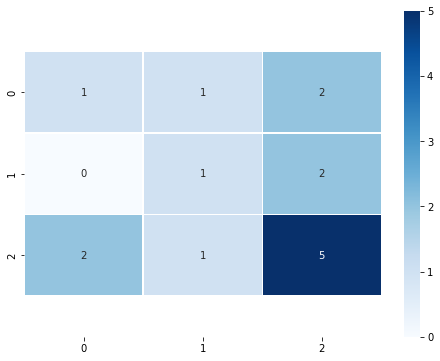

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
actual = [1,1,1,0,0,0,0,2,2,2,2,2,2,2,2]
prediction = [1,2,2,0,2,2,1,2,0,1,0,2,2,2,2]
c_mat = confusion_matrix(actual, prediction)
plt.figure(figsize=(8,6))
sns.heatmap(c_mat, annot=True, fmt='d', cmap='Blues', linewidths = .5)
b,t = plt.ylim()
b += 0.5
t -= 0.5
plt.ylim(b,t)
plt.show()

# Transfer Learning (전이 학습)
- 기존의 지식을 우리가 풀고자 하는 문제에 적용하여 학습하는 방법
- 다른 데이터를 가지고 오거나 다른 업무에서 학습된 모델을 적용하는 것 등등

### Pretrained model
- ImageNet 데이터 학습 모델들 사용
- torchvision.models as models

In [ ]:
import torchvision.models as models
alexnet = models.alexnet().to(device)
resnet18 = models.resnet18().to(device)
vgg16 = models.vgg16().to(device)
densenet = models.densenet161().to(device)
inception = models.inception_v3().to(device)
googlenet = models.googlenet().to(device)
shufflenet = models.shufflenet_v2_x1_0().to(device)
mobilenet_v2 = models.mobilenet_v2().to(device)
resnext50_32x4d = models.resnext50_32x4d().to(device)
wide_resnet50_2 = models.wide_resnet50_2().to(device)
mnasnet = models.mnasnet1_0().to(device)

In [ ]:
model = torchvision.models.resnet18(pretrained=True)
model.conv1 = nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### Model freezing
- 기존의 일부 모델 변수들을 그대로 사용하기 위해 업데이트가 되지 않도록 하는 방법
- 사전 학습된 변수를 그대로 유지할 수 있어 학습 속도와 정확도를 향상시킬 수 있고, 다른 모델과 붙여 다른 구조 만들 수 있음
- CNN에서는 피쳐 추출 부분은 프리징을 시키고 분류 파트만 학습을 진행하기도 함.

In [ ]:
model = torchvision.models.alexnet(pretrained=True)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs,10)
model = model.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
# 모델 파라미터명 확인
for i,(name,param) in enumerate(model.named_parameters()):
  print(i,name)

0 features.0.weight
1 features.0.bias
2 features.3.weight
3 features.3.bias
4 features.6.weight
5 features.6.bias
6 features.8.weight
7 features.8.bias
8 features.10.weight
9 features.10.bias
10 classifier.1.weight
11 classifier.1.bias
12 classifier.4.weight
13 classifier.4.bias
14 classifier.6.weight
15 classifier.6.bias


In [ ]:
# 변수 프리징
for i,(name,param) in enumerate(model.named_parameters()):
  param.requires_grad = False
  if i == 9:
    print('end')
    break

end


In [ ]:
# Requires_grad 확인
f_list = [0,3,6,8,10]
c_list = [1,4,6]
for i in f_list:
  print(model.features[i].weight.requires_grad)
  print(model.features[i].bias.requires_grad)
for j in c_list:
  print(model.classifier[j].weight.requires_grad)
  print(model.classifier[j].bias.requires_grad)

False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True


# Semi-supervised learning (준지도 학습)
- 정답이 있는 데이터와 정답이 없는 데이터를 함께 사용하여 모델을 학습

### Pseudo Labeling (의사 라벨링)
- 준지도 학습 중 가장 기본적으로 사용되는 방법
- 이미 학습된 모델을 이용하여 라벨링이 되지 않은 데이터를 예측한 후, 그 예측값을 기준으로 라벨링을 하여 기존의 학습 데이터와 함께 학습에 사용하는 방법

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

*tqdm : for문의 진행 상황을 알려주는 라이브러리

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [14]:
# 데이터세트 정의
class MyDataset(Dataset):
  def __init__(self, x_data, y_data, transform=None):
    self.x_data = x_data
    self.y_data = y_data
    self.transform = transform
    self.len = len(y_data)

  def __getitem__(self, index):
    sample = self.x_data[index], self.y_data[index]
    if self.transform:
      sample = self.transform(sample)
    return sample

  def __len__(self):
    return self.len

In [15]:
# 데이터 전처리 정의
class TrainTransform:
  def __call__(self,sample):
    inputs, labels = sample
    transf = transforms.Compose([transforms.ToPILImage(),
                                 transforms.RandomHorizontalFlip(),transforms.ToTensor()])
    final_output = transf(inputs)
    return final_output, labels

In [16]:
# 데이터 세트 나누기
def balanced_subset(data, labels, num_cls, num_data):
  num_data_per_class = num_data // num_cls
  data1 = torch.tensor([],dtype=torch.float)
  data2 = torch.tensor([],dtype=torch.float)
  labels1 = torch.tensor([],dtype=torch.long)
  labels2 = torch.tensor([],dtype=torch.long)
  for cls in range(num_cls):
    idx = np.where(labels.numpy()==cls)[0]
    shuffled_idx = np.random.choice(len(idx),len(idx),replace=False)
    data1 = torch.cat([data1,data[shuffled_idx[:num_data_per_class]]],dim=0)
    data2 = torch.cat([data2, data[shuffled_idx[num_data_per_class:]]], dim=0)
    labels1 = torch.cat([labels1, labels[shuffled_idx[:num_data_per_class]]],dim=0)
    labels2 = torch.cat([labels2, labels[shuffled_idx[num_data_per_class:]]],dim=0)

  return data1,data2,labels1, labels2

In [17]:
trainset = torchvision.datasets.MNIST(root='./data',train=True, download=True)
labeled_data, unlabeled_data, labels, unlabels = balanced_subset(trainset.data, trainset.targets, num_cls=10, num_data=2000)
train_images,val_images,train_labels,val_labels = balanced_subset(labeled_data, labels, num_cls=10, num_data=1000)

In [18]:
train_images = train_images.unsqueeze(1)
val_images = val_images.unsqueeze(1)
trainset = MyDataset(train_images, train_labels, transform=TrainTransform())
trainloader= torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
validationset = MyDataset(val_images, val_labels)
valloader = torch.utils.data.DataLoader(validationset, batch_size=128, shuffle=False)
unlabeled_images= unlabeled_data.unsqueeze(1)
unlabeledset = MyDataset(unlabeled_images, unlabels)
unlabelloader= torch.utils.data.DataLoader(unlabeledset, batch_size=256, shuffle=True)

In [19]:
transform = transforms.Compose([transforms.ToTensor()])
testset = torchvision.datasets.MNIST(root='./data',train=False,download=True, transform=transform)
testloadr = torch.utils.data.DataLoader(testset, batch_size= 100, shuffle=False)

In [20]:
# 모델 정의
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(1,64,3),nn.ReLU(),
        nn.MaxPool2d(2,2),
        nn.Conv2d(64,192,3,padding=1), nn.ReLU(),
        nn.MaxPool2d(2,2)
    )
    self.classifier = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(192*6*6,1024),nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(1024,512), nn.ReLU(),
        nn.Linear(512,10)
    )
  
  def forward(self,x):
    x = self.features(x)
    x = x.view(-1,192*6*6)
    x = self.classifier(x)
    return x

model = Net().to(device)

In [21]:
# 손실 함수 및 최적화 기법 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=1e-3)

In [22]:
# 정확도 평가 함수 정의
def accuracy(dataloader):
  correct = 0
  total = 0
  with torch.no_grad():
    model.eval()
    for data in dataloader:
      images, labels = data[0].to(device), data[1].to(device)
      outputs= model(images)
      _, predicted = torch.max(outputs,data,1)
      total += labels.size(0)
      correct += (predicted==labels).sum().item()

  acc = 100*correct/total
  model.train()
  return acc

In [ ]:
# 지도 학습 수행
best_acc = 0
for epoch in range(10):
  correct = 0
  total = 0
  for traindata in trainloader:
    inputs, labels = traindata[0].to(device), traindata[1].to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    _, predicted = torch.max(outputs.detach(),1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
  val_acc = accuracy(valloader)
  
  if val_acc >= best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), './models/cifar_model_for_pseudo_baseline.pth')
    print('[%d] train acc: %.2f, validation acc: %.2f - Saved the best model' %(epoch,100*correct/total,val_acc))
  elif epoch%10 == 0:
    print('[%d] train acc: %.2f, validation acc: %.2f' % (epoch, 100*correct/total,val_acc))

In [ ]:
# 지도 학습 성능 평가
model.load_state_dict(torch.load('./models/cifar_model_for_pseudo_baseline.pth'))
accuracy(testloader)